# TP 20ng : Classification sur le corpus 20newsgroups
WANG Xiaobo, INALCO

Le TP réalisera une classification supervisée sur le corpus 20Newsgroups à l’aide de modèles linéaires (J'ai choisi trois modèles ici : LinearSVC, Logistic Regression et Naive Bayes). Les données sont chargées depuis scikit-learn avec le split standard train/test et le prétraitement TF–IDF.  

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [6]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

## 1. Chargement du corpus
Le corpus se trouve dans : https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset

In [7]:
data = fetch_20newsgroups(
    subset="all",
    remove=("headers", "footers", "quotes")
)

texts = data.data
labels = data.target
target_names = data.target_names

# Voir le nombre de documents et de classes
print("Nombre total de documents :", len(texts))
print("Nombre de classes :", len(target_names))

Nombre total de documents : 18846
Nombre de classes : 20


In [8]:
train = fetch_20newsgroups(
    subset="train",
    remove=("headers", "footers", "quotes"),
    random_state=SEED
)
test = fetch_20newsgroups(
    subset="test",
    remove=("headers", "footers", "quotes"),
    random_state=SEED
)
X_train, y_train = train.data, train.target
X_test, y_test = test.data, test.target

print("Nombre de documents (train) :", len(X_train))
print("Nombre de documents (test)  :", len(X_test))

Nombre de documents (train) : 11314
Nombre de documents (test)  : 7532


## 2. Vectorization
J'utilise TF-IDF pour la représentation des documents.

In [10]:
vectorizer = TfidfVectorizer(
    stop_words="english", # pour retirer les mots inutiles
    ngram_range=(1, 2), # ajouter unigramme et bigramme
    max_df=0.7 # ignore les termes apparaissant dans plus de 70% des documents.
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF–IDF shape (train) :", X_train_tfidf.shape)
print("TF–IDF shape (test)  :", X_test_tfidf.shape)

TF–IDF shape (train) : (11314, 943737)
TF–IDF shape (test)  : (7532, 943737)


PS: J’ai également testé une vectorisation TF–IDF utilisant uniquement des unigrammes (ngram_range=(1,1)), afin d’évaluer l’impact des bigrammes sur la qualité de la classification. Les scores sont moins bien que ceux obtenus avec ngram_range=(1,2). 

À mon avis, les bigrammes peuvent capturent des expressions techniques, des constructions typiques de certains groupes de discussion, ainsi que des cooccurrences discriminantes que les unigrammes seuls ne peuvent pas représenter. Comme la dimension avec bigrammes n'a pas beaucoup augmenté, j'ai ainsi garder les bigrammes.

Avec ces paramètres, surtout avec les bigrammes, la matrice TF–IDF atteint une haute dimension (943 737 features). On va dire les données textuelles sont sparse.

## 3. Entraînement des modèles
J'ai choisi deux modèles linéaires classiques adaptés aux données TF–IDF :

- LinearSVC : très performant sur les données textuelles, robuste et rapide.  
- Logistic Regression : modèle probabiliste permettant une comparaison utile. 

#### 3.1 LinearSVC

In [11]:
svc_model = LinearSVC(
    # la régularisation du modèle, 1.0 est standard et évite le surapprentissage
    C=1.0,
    # avec 20 classes et une grande dimension, il faut un nombre d’itérations plus élevé
    max_iter=1000,
    # le nombre de features est beaucoup plus que le nombre d’échantillons
    dual=False,
    random_state=SEED
)

svc_model.fit(X_train_tfidf, y_train)

y_pred_svc = svc_model.predict(X_test_tfidf)

svc_accuracy = accuracy_score(y_test, y_pred_svc)
svc_f1_macro = f1_score(y_test, y_pred_svc, average='macro')
svc_f1_weighted = f1_score(y_test, y_pred_svc, average='weighted')

print("Accuracy: ", svc_accuracy)
print("F1-Score (macro): ", svc_f1_macro)
print("F1-Score (weighted): ", svc_f1_weighted)

Accuracy:  0.7040626659585767
F1-Score (macro):  0.6911847845717194
F1-Score (weighted):  0.7015274853752238


#### 3.2 Régression Logistique

In [12]:
lr_model = LogisticRegression(
    # pareil avec svc pour bien comparer
    C=1.0,
    max_iter=1000,
    # robuste pour multi-classes
    solver='lbfgs',
    random_state=SEED
)

lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1_macro = f1_score(y_test, y_pred_lr, average='macro')
lr_f1_weighted = f1_score(y_test, y_pred_lr, average='weighted')

print("Accuracy: ", lr_accuracy)
print("F1-Score (macro): ", lr_f1_macro)
print("F1-Score (weighted): ", lr_f1_weighted)

Accuracy:  0.6865374402549124
F1-Score (macro):  0.6667798553647162
F1-Score (weighted):  0.6800686334516194


#### 3.3 Naive Bayes

In [13]:
nb_model = MultinomialNB()

nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)

nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_f1_macro = f1_score(y_test, y_pred_nb, average='macro')
nb_f1_weighted = f1_score(y_test, y_pred_nb, average='weighted')

print("Accuracy: ", nb_accuracy)
print("F1-Score (macro): ", nb_f1_macro)
print("F1-Score (weighted): ", nb_f1_weighted)

Accuracy:  0.6741901221455124
F1-Score (macro):  0.6424962318311604
F1-Score (weighted):  0.6603120385638582


## 4. Visualisation

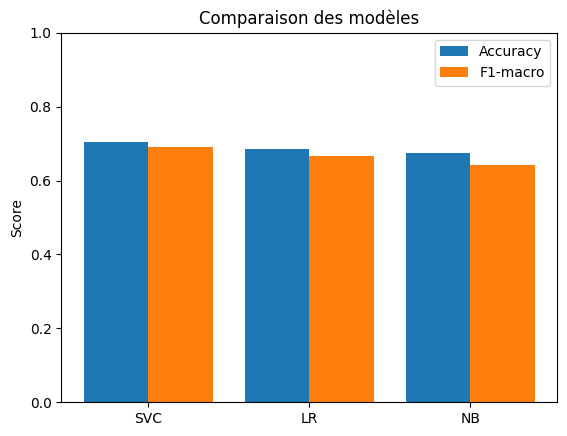

In [14]:
models = ["SVC", "LR", "NB"]
accuracies = [svc_accuracy, lr_accuracy, nb_accuracy]
f1_macros = [svc_f1_macro, lr_f1_macro, nb_f1_macro]

x = range(len(models))

plt.bar(x, accuracies, width=0.4, label="Accuracy")
plt.bar([i + 0.4 for i in x], f1_macros, width=0.4, label="F1-macro")

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1)

plt.ylabel("Score")
plt.title("Comparaison des modèles")
plt.legend()
plt.show()

#### Matrix de confusion 

In [20]:
import seaborn as sns

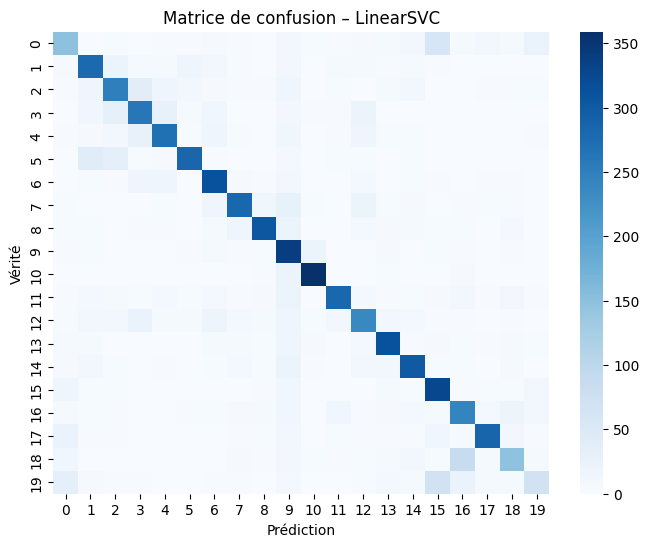

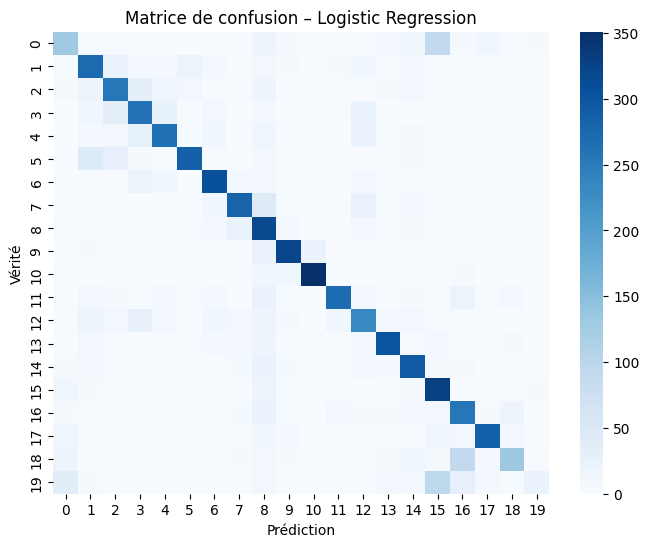

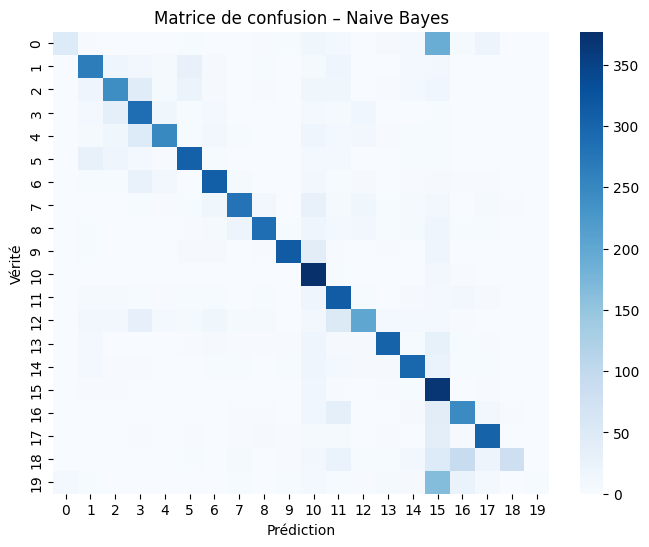

In [21]:
models_cm = {
    "LinearSVC": y_pred_svc,
    "Logistic Regression": y_pred_lr,
    "Naive Bayes": y_pred_nb
}

for name, preds in models_cm.items():
    cm = confusion_matrix(y_test, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap="Blues", annot=False)
    plt.title(f"Matrice de confusion – {name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité")
    plt.show()

## 5. Conclusion

Les résultats obtenus montrent que le modèle **LinearSVC** surpasse légèrement la 
**Régression Logistique** et **Naive Bayes** sur l’ensemble des indicateurs mesurés.

Voici les résultats : 

LinearSVC :
- Accuracy : 0.7041  
- F1-macro : 0.6912  
- F1-weighted : 0.7015  

Régression Logistique :
- Accuracy : 0.6865  
- F1-macro : 0.6668  
- F1-weighted : 0.6801

Naive Bayes :
- Accuracy : 0.6742
- F1-macro : 0.6425  
- F1-weighted : 0.6603

Selon les résultats : le modèle LinearSVC obtient les meilleurs résultats sur l’ensemble des métriques. Les performances de la Régression Logistique restent proches, mais légèrement inférieures. Quant à Naive Bayes, il constitue un bon modèle de référence, mais son efficacité est limitée dans ce contexte. Je suppose que les modèles probabilistes simples, comme Naive Bayes, ont tendance à perdre en précision lorsque les relations entre les features deviennent complexes, il performe donc moins bien ici.

Pour les matrices de confusion : 

1. LinearSVC

La diagonale de la matrice est bien marquée, ce qui montre une bonne capacité du modèle à différencier les 20 classes. Il y a quelques confusions apparaissent entre des catégories thématiquement proches, mais dans l'ensemble, les erreurs restent limitées et n’impactent pas fortement les scores globaux.

2. Régression Logistique

La structure de la matrice est similaire à celle de LinearSVC, mais on observe un peu plus de points hors diagonale. Cela explique la légère baisse des performances.

3. Naive Bayes

La matrice révèle que Naive Bayes a plus d’erreurs. Comme le modèle repose sur une hypothèse d’indépendance entre les termes, qui n’est pas toujours adaptée à un corpus aussi varié. Certaines classes sont difficilement distinguées et entraînent un nombre plus élevé de mauvaises prédictions.

En gros, LinearSVC est le modèle le plus performant pour cette tâche. Il gère efficacement la grande dimension du TF-IDF et s'adapte bien aux structures complexes des textes. La Régression Logistique est légèrement moins robuste dans ce cadre, mais reste quand même une alternative fiable. Naive Bayes, si dans un corpus si riches, il atteint ses limites, je pense qu'il peut être intéressant comme baseline.